<a href="https://colab.research.google.com/github/GabrielReis2701/Rede-neural_do_zero/blob/main/Rede_neural_do_zero.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import torch
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torch import nn, optim

In [ ]:
transform = transforms.ToTensor() #definindo a conversão de imagem para tensor

trainset = datasets.MNIST('./MNIST_data/', download=True, train=True, transform=transform) # Carrega a parte de treino do dataset
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True) # Cria um buffer para pegar os dados por partes
valset = datasets.MNIST('./MNIST_data/', download=True, train=False, transform=transform) # Carrega a parte de validação do dataset
valloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=True) # Cria um buffer para pegar os dados por partes

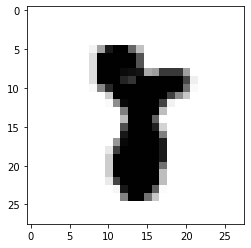

In [ ]:
dataiter = iter(trainloader)
imagens, etiquetas = dataiter.next()
plt.imshow(imagens[0].numpy().squeeze(), cmap='gray_r');

In [ ]:
print(imagens[0].shape) #Para verificar as dimensões do tensor de cada imagem
print(etiquetas[0].shape) #Para verificar as dimensões do tensor de cada etiqueta

torch.Size([1, 28, 28])
torch.Size([])


In [ ]:
class Modelo(nn.Module):
    def _init_(self):
      super(Modelo, self)._init_()
      self.linear1 = nn.Linear(28*28, 128) # Camada de entrada, 784 neurônios que se ligam a 128
      self.linear2 = nn.Linear(128, 64) # Camada interna 1, 128 neurônios que se ligam a 64
      self.linear3 = nn.Linear(64, 10) # Camada interna 2, 64 neurônios que se ligam a 10
      #Para a camada de saida não e necessario definir nada pois só é preciso pegar o output da camada interna 2

    def forward(self,x):
      x = F.relu(self.linear1(x)) # função de ativação da camada de entrada para a camada interna 1
      x = F.relu(self.linear2(x)) # função de ativação da camada interna 1 para a camada interna 2
      x = self.linear3(x) # função de ativação da camada interna 2 para a camada de saida, nesse caso f(x) = x
      return F.log_softmax(x, dim=1) # dados utilizados para calcular a perda

In [ ]:
def treino(modelo, trainloader, device):
  otimizador = optim.SGD(modelo.parameters(), lr=0.01, momentum=0.5) # define a politica de atualização dos pesos e da bias
  inicio = time() # timer para saber quanto tempo levou o treino
  criterio = nn.NLLLoss() # definindo o criterio para calcular a perda
  EPOCHS = 100 # numero de epochs que p algoritmo rodará
  modelo.train() # ativando o modo de treinamento do modelo
  for epoch in range(EPOCHS):
    perda_acumulada =0 # inicialização da perda acumulada da epoch em questão
    for imagens, etiquetas in trainloader:
      imagens = imagens.view(imagens.shape[0], -1) # convertendo as imagens para vetores de 28*28 casas
      otimizador.zero_grad() # zerando os gradientes por conta do ciclo anterior
      output = modelo(imagens.to(device)) # colocando os dados no modelo
      perda_instantanea = criterio(output, etiquetas.to(device)) # calculando a perda da epoch em questão
      perda_instantanea.backward() # back propagation a partir da perda
      otimizador.step() # atualizando os pesos e a bias
      perda_acumulada += perda_instantanea.item() # atualização da perda acumulada
    else:
      print("Epoch {} - perda resultante: {}".format(epoch+1, perda_acumulada/len(trainloader)))
  print("\nTempo de treino (em minutos) = ",(time()-inicio)/60)

In [ ]:
def validacao(modelo, valloader, device):
  conta_corretas, conta_todas = 0, 0
  for imagens,etiquetas in valloader:
    for i in range(len(etiquetas)):
      img = imagens[i].view(1, 784)
      #desativar o autograd para acelerar a validação. Grafos computacionais dinâmicos tem um custo alto de processamento
      with torch.no_grad():
        logps = modelo(img.to(device)) # output do modelo em escala logaritmica
      ps = torch.exp(logps) # converte output para escala normal( lembrando que é um tensor)
      probab = list(ps.cpu().numpy()[0])
      etiqueta_pred = probab.index(max(probab)) # converte o tensor em um número, no caso, o numero que o modelo previu
      etiqueta_certa = etiquetas.numpy()[i]
      if(etiqueta_certa == etiqueta_pred):  #compara a previsão com o valor correto
        conta_corretas += 1
      conta_todas += 1
  print("Total de imagens testadas =", conta_todas)
  print("\nPrecisão do modelo = {} %".format((conta_corretas*100)/conta_todas))

In [ ]:
modelo = Modelo()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
modelo.to(device)

Modelo()